In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random, math
import seaborn as sns
import os
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA

2023-05-16 19:14:35.813062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(tf.__version__)

2.12.0


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ls /content/drive/'My Drive'/'RMIT PROGRAMMING'/'Machine Learning A2'/

In [ ]:
# cd /content/drive/'My Drive'/'RMIT PROGRAMMING'/'Machine Learning A2'/

In [ ]:
# ls

In [ ]:
# pwd

In [4]:
dfMain = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
dfExtra = pd.read_csv('Image_classification_data/data_labels_extraData.csv')
dfJoined = pd.concat([dfMain, dfExtra])
display(dfJoined)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0
...,...,...,...,...,...,...
10379,20028,99,20028.png,NaN,NaN,0
10380,20029,99,20029.png,NaN,NaN,0
10381,20030,99,20030.png,NaN,NaN,0
10382,20031,99,20031.png,NaN,NaN,0


In [5]:
dfJoined.shape

(20280, 6)

In [6]:
dfJoined.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


In [7]:
dfJoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InstanceID    20280 non-null  int64  
 1   patientID     20280 non-null  int64  
 2   ImageName     20280 non-null  object 
 3   cellTypeName  9896 non-null   object 
 4   cellType      9896 non-null   float64
 5   isCancerous   20280 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


In [8]:
dfJoined.describe()

,InstanceID,patientID,cellType,isCancerous
count,20280.000000,20280.000000,9896.000000,20280.000000
mean,11163.660848,55.681065,1.501516,0.348570
std,6481.457867,28.891837,0.954867,0.476529
min,1.000000,1.000000,0.000000,0.000000
25%,5551.750000,29.000000,1.000000,0.000000
50%,11111.500000,63.000000,2.000000,0.000000
75%,16756.250000,81.000000,2.000000,1.000000
max,22444.000000,99.000000,3.000000,1.000000


In [9]:
dfJoined.dtypes

InstanceID        int64
patientID         int64
ImageName        object
cellTypeName     object
cellType        float64
isCancerous       int64
dtype: object

In [10]:
dfJoined.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [11]:
dfJoined.isnull().sum()

InstanceID          0
patientID           0
ImageName           0
cellTypeName    10384
cellType        10384
isCancerous         0
dtype: int64

([0, 1, 2, 3],
 [Text(0, 0, 'fibroblast'),
  Text(1, 0, 'inflammatory'),
  Text(2, 0, 'others'),
  Text(3, 0, 'epithelial')])

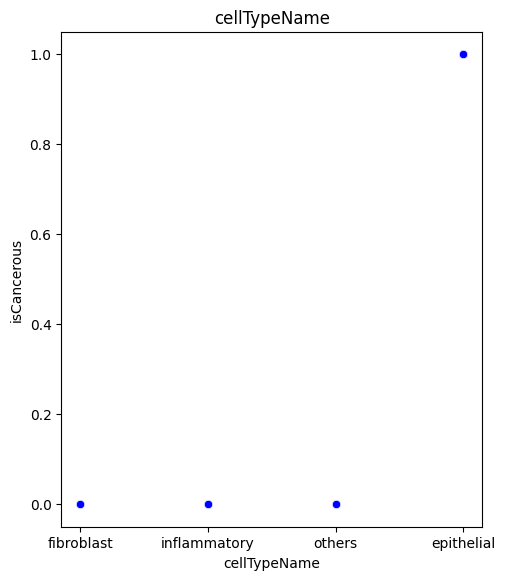

In [12]:
plt.figure(figsize=(25,45))
plt.subplot(6,4,1)
sns.scatterplot(data=dfMain, x=dfMain['cellTypeName'], y='isCancerous', color='blue')
plt.title('cellTypeName')
plt.xticks(rotation='horizontal')

<Axes: xlabel='Is Cancerous'>

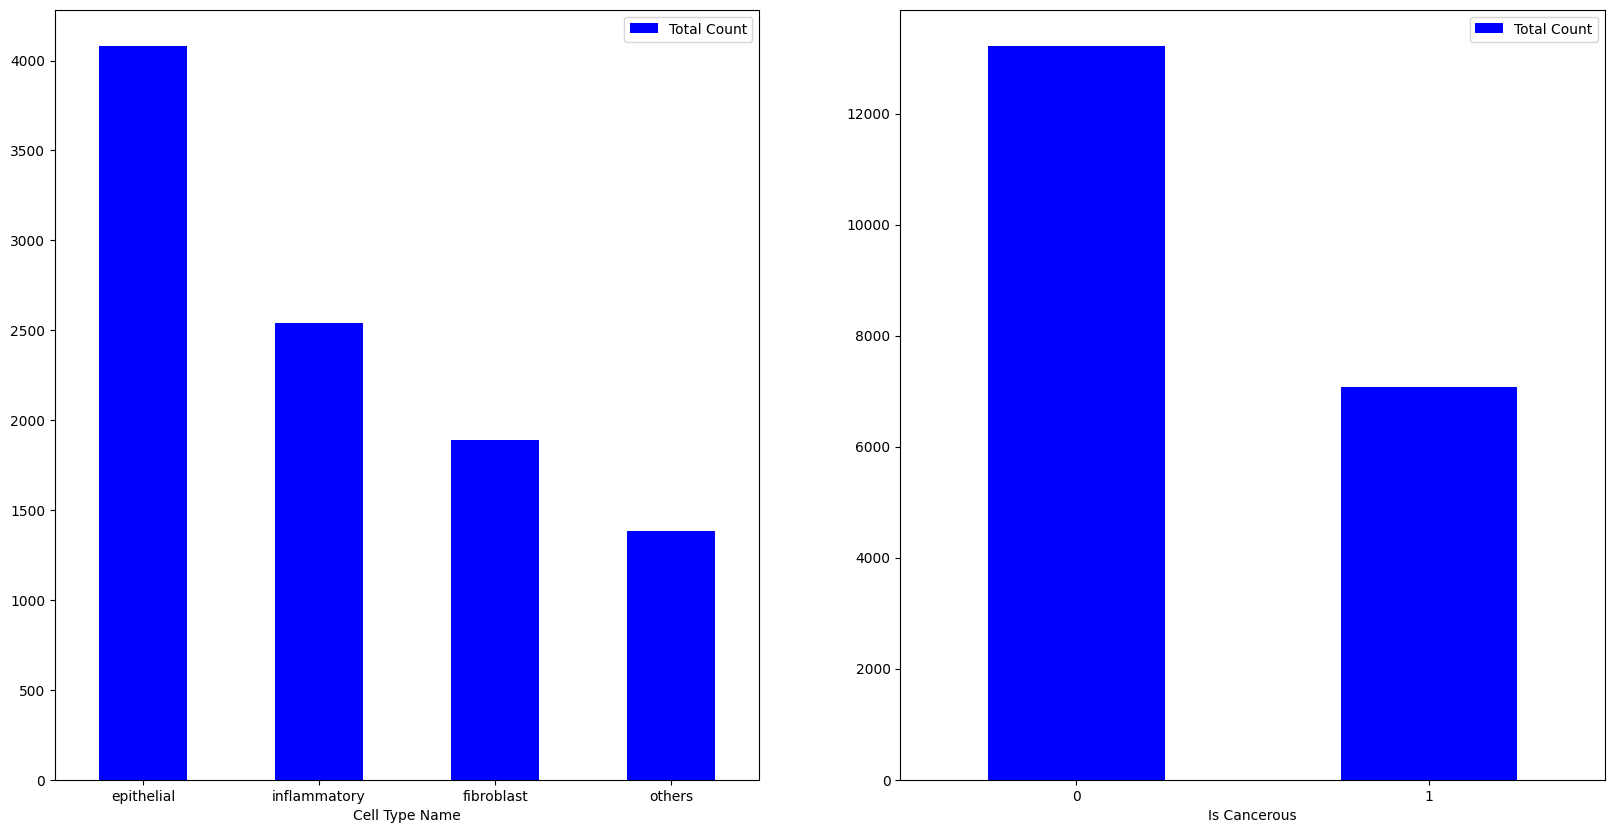

In [13]:
dfCellCounts = pd.DataFrame(dfMain.cellTypeName.value_counts().reset_index().values, columns=['Cell Type Name', 'Total Count'])
dfCancerousCounts = pd.DataFrame(dfJoined.isCancerous.value_counts().reset_index().values, columns=['Is Cancerous', 'Total Count'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
dfCellCounts.plot(kind='bar', x='Cell Type Name', y='Total Count', color='blue', ax=axes[0], rot=0)
dfCancerousCounts.plot(kind='bar', x='Is Cancerous', y='Total Count', color='blue', ax=axes[1], rot=0)

## Datasplit for Cell Type Classification

In [14]:
# DF For Cell Type Classification
dfPatientImagesCount_CT = pd.DataFrame(dfMain.patientID.value_counts().reset_index().values, columns=['Patient ID', 'Total Images for Patient'])
dfPatientImagesCount_CT = dfPatientImagesCount_CT.sort_values('Patient ID', ascending=True)
print("Average number of images per patient ID: ", dfPatientImagesCount_CT['Total Images for Patient'].mean().round())

Average number of images per patient ID:  165.0


In [15]:
moreThan300 = []
lessThan100 = []
theRest = []

print("DF LENGTH: ", len(dfPatientImagesCount_CT))

for index, patient in dfPatientImagesCount_CT.iterrows():
    imageCount = patient['Total Images for Patient'].astype('int')
    if imageCount > 300: 
        moreThan300.append(patient['Patient ID'])
    elif imageCount < 100:
        lessThan100.append(patient['Patient ID'])
    else:
        theRest.append(patient['Patient ID'])

print(moreThan300)
print(lessThan100)
print(theRest)

total = len(moreThan300) + len(lessThan100) + len(theRest)
print("Total: ", total)

DF LENGTH:  60
[8, 9, 10, 17, 18, 20, 29, 54]
[1, 2, 11, 27, 28, 32, 34, 35, 37, 38, 45, 56]
[3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 19, 21, 22, 23, 24, 25, 26, 30, 31, 33, 36, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60]
Total:  60


In [16]:
def customSplitter(list, train):
    random.shuffle(list)
    splitIndex = math.ceil(len(list) * train) 
    training = list[:splitIndex]
    testing = list[splitIndex:]
    return training, testing

In [17]:
splits1 = customSplitter(moreThan300, 0.8)
splits2 = customSplitter(lessThan100, 0.8)
splits3 = customSplitter(theRest, 0.8)

trainingPatientID_CT = splits1[0] + splits2[0] + splits3[0]
testingPatientID_CT = splits1[1] + splits2[1] + splits3[1]
print(trainingPatientID_CT)
print(testingPatientID_CT)

[20, 17, 18, 8, 10, 29, 9, 34, 38, 1, 27, 37, 28, 2, 45, 11, 35, 3, 44, 15, 53, 25, 22, 7, 46, 36, 52, 13, 49, 40, 50, 33, 39, 30, 23, 55, 42, 57, 48, 43, 59, 31, 14, 41, 6, 24, 47, 19, 51]
[54, 56, 32, 4, 16, 60, 58, 21, 12, 5, 26]


/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/1549123549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set_CT['Colour'] = 'blue'
/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/1549123549.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set_CT['Colour'] = 'red'


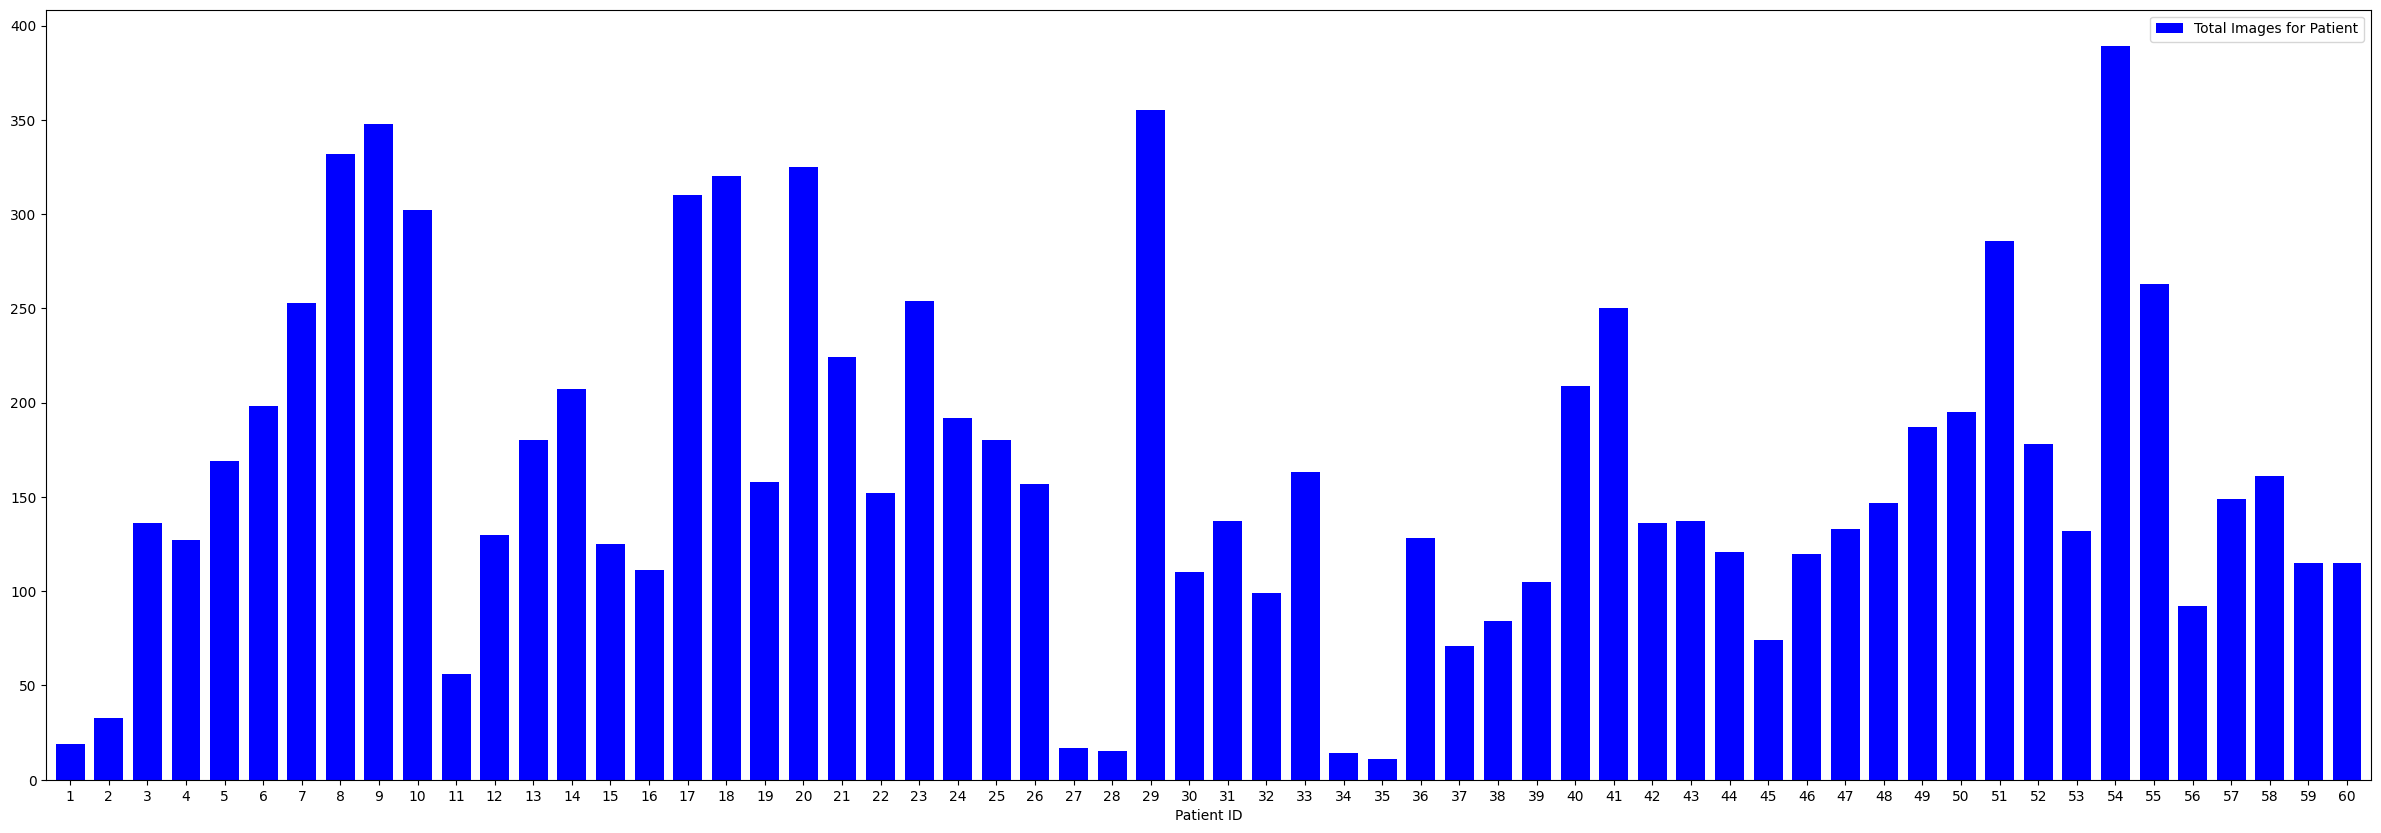

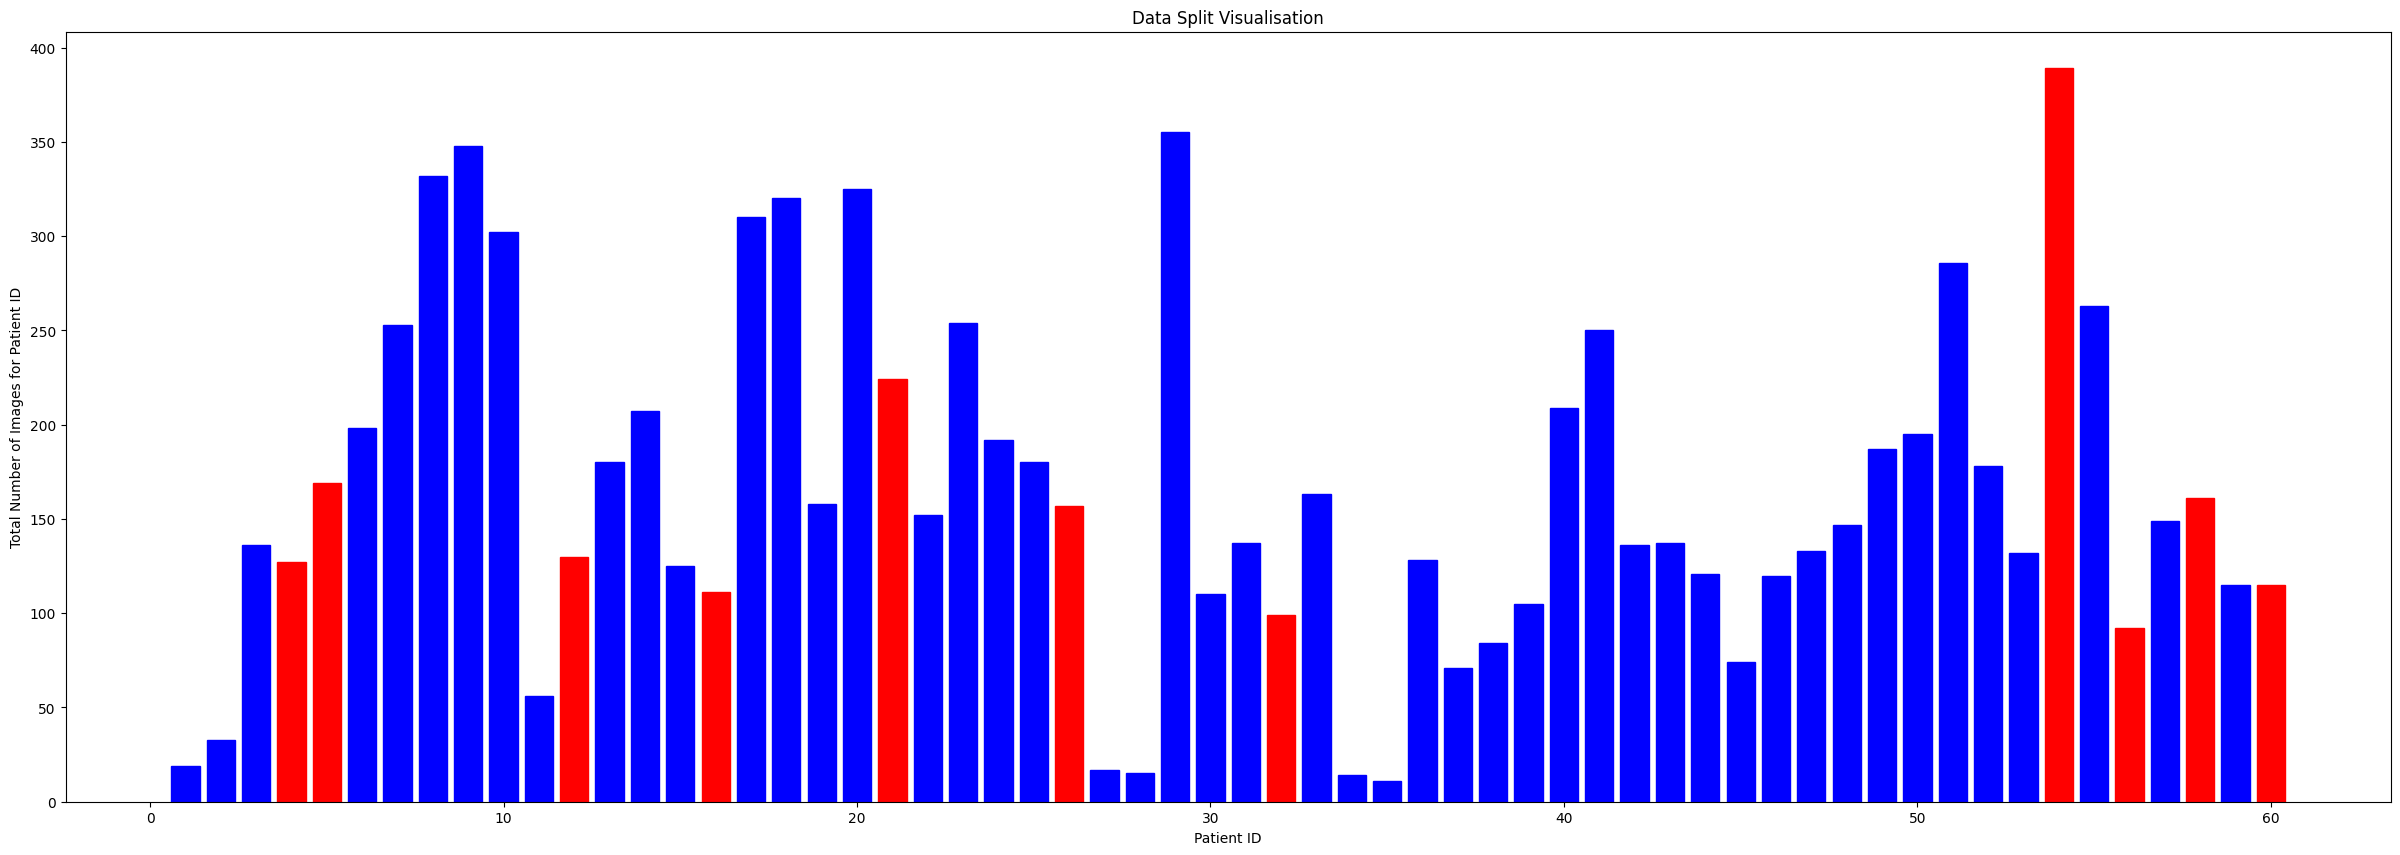

Training Data = BLUE
Average number of Training:  166.0

Testing Data = RED
Average number of Testing:  161.0


In [18]:
training_set_CT = dfPatientImagesCount_CT[dfPatientImagesCount_CT['Patient ID'].isin(trainingPatientID_CT)]
testing_set_CT = dfPatientImagesCount_CT[dfPatientImagesCount_CT['Patient ID'].isin(testingPatientID_CT)] 

training_set_CT['Colour'] = 'blue'
testing_set_CT['Colour'] = 'red'
dfSplitData = pd.concat([training_set_CT, testing_set_CT])
dfSplitData.sort_values(['Patient ID'], ascending=True, inplace=True)

dfPatientImagesCount_CT.plot(kind='bar', x='Patient ID', y='Total Images for Patient', color='blue', figsize=(30, 10), rot=0, width=0.75)

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(dfSplitData['Patient ID'], dfSplitData['Total Images for Patient'])

for i, bar in enumerate(bars):
    bar.set_color(dfSplitData.iloc[i]['Colour'])

ax.set_xlabel('Patient ID')
ax.set_ylabel('Total Number of Images for Patient ID')
ax.set_title('Data Split Visualisation')

plt.show()

print("Training Data = BLUE")
print("Average number of Training: ", training_set_CT['Total Images for Patient'].mean().round())
print()
print("Testing Data = RED")
print("Average number of Testing: ", testing_set_CT['Total Images for Patient'].mean().round())

## Datasplit for Cancerous Classification

In [23]:
# DF For Cell Type Classification
dfPatientImagesCount_IC = pd.DataFrame(dfJoined.patientID.value_counts().reset_index().values, columns=['Patient ID', 'Total Images for Patient'])
dfPatientImagesCount_IC = dfPatientImagesCount_IC.sort_values('Patient ID', ascending=True)
print("Average number of images per patient ID: ", dfPatientImagesCount_IC['Total Images for Patient'].mean().round())

Average number of images per patient ID:  207.0


In [24]:
moreThan350 = []
lessThan100 = []
theRest = []

print("DF LENGTH: ", len(dfPatientImagesCount_IC))

for index, patient in dfPatientImagesCount_IC.iterrows():
    imageCount = patient['Total Images for Patient'].astype('int')
    if imageCount > 350: 
        moreThan350.append(patient['Patient ID'])
    elif imageCount < 100:
        lessThan100.append(patient['Patient ID'])
    else:
        theRest.append(patient['Patient ID'])

print(moreThan350)
print(lessThan100)
print(theRest)

total = len(moreThan350) + len(lessThan100) + len(theRest)
print("Total: ", total)

DF LENGTH:  98
[29, 54, 66, 67, 68, 77, 78, 79, 80, 81, 85, 86, 88, 89, 90, 91, 92]
[1, 2, 11, 27, 28, 32, 34, 35, 37, 38, 45, 56, 62, 63, 64, 72, 73, 74, 75, 93, 94, 95, 96, 98, 99]
[3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 33, 36, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 60, 61, 65, 69, 70, 71, 82, 83, 84, 87, 97]
Total:  98


In [25]:
splits1 = customSplitter(moreThan350, 0.8)
splits2 = customSplitter(lessThan100, 0.8)
splits3 = customSplitter(theRest, 0.8)

trainingPatientID_IC = splits1[0] + splits2[0] + splits3[0]
testingPatientID_IC = splits1[1] + splits2[1] + splits3[1]
print(trainingPatientID_IC)
print(testingPatientID_IC)

[77, 81, 89, 91, 88, 80, 29, 54, 79, 67, 66, 90, 86, 85, 72, 94, 96, 1, 32, 93, 11, 38, 99, 56, 62, 2, 45, 64, 63, 75, 98, 35, 95, 28, 61, 24, 44, 31, 57, 4, 8, 46, 49, 65, 71, 97, 12, 84, 36, 20, 39, 48, 22, 59, 83, 17, 40, 47, 21, 70, 50, 14, 60, 43, 26, 7, 87, 30, 69, 13, 6, 5, 58, 53, 82, 51, 18, 3, 33]
[68, 78, 92, 27, 37, 74, 34, 73, 19, 15, 9, 42, 52, 16, 10, 55, 23, 41, 25]


/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/436633843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set_IC['Colour'] = 'blue'
/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/436633843.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set_IC['Colour'] = 'red'


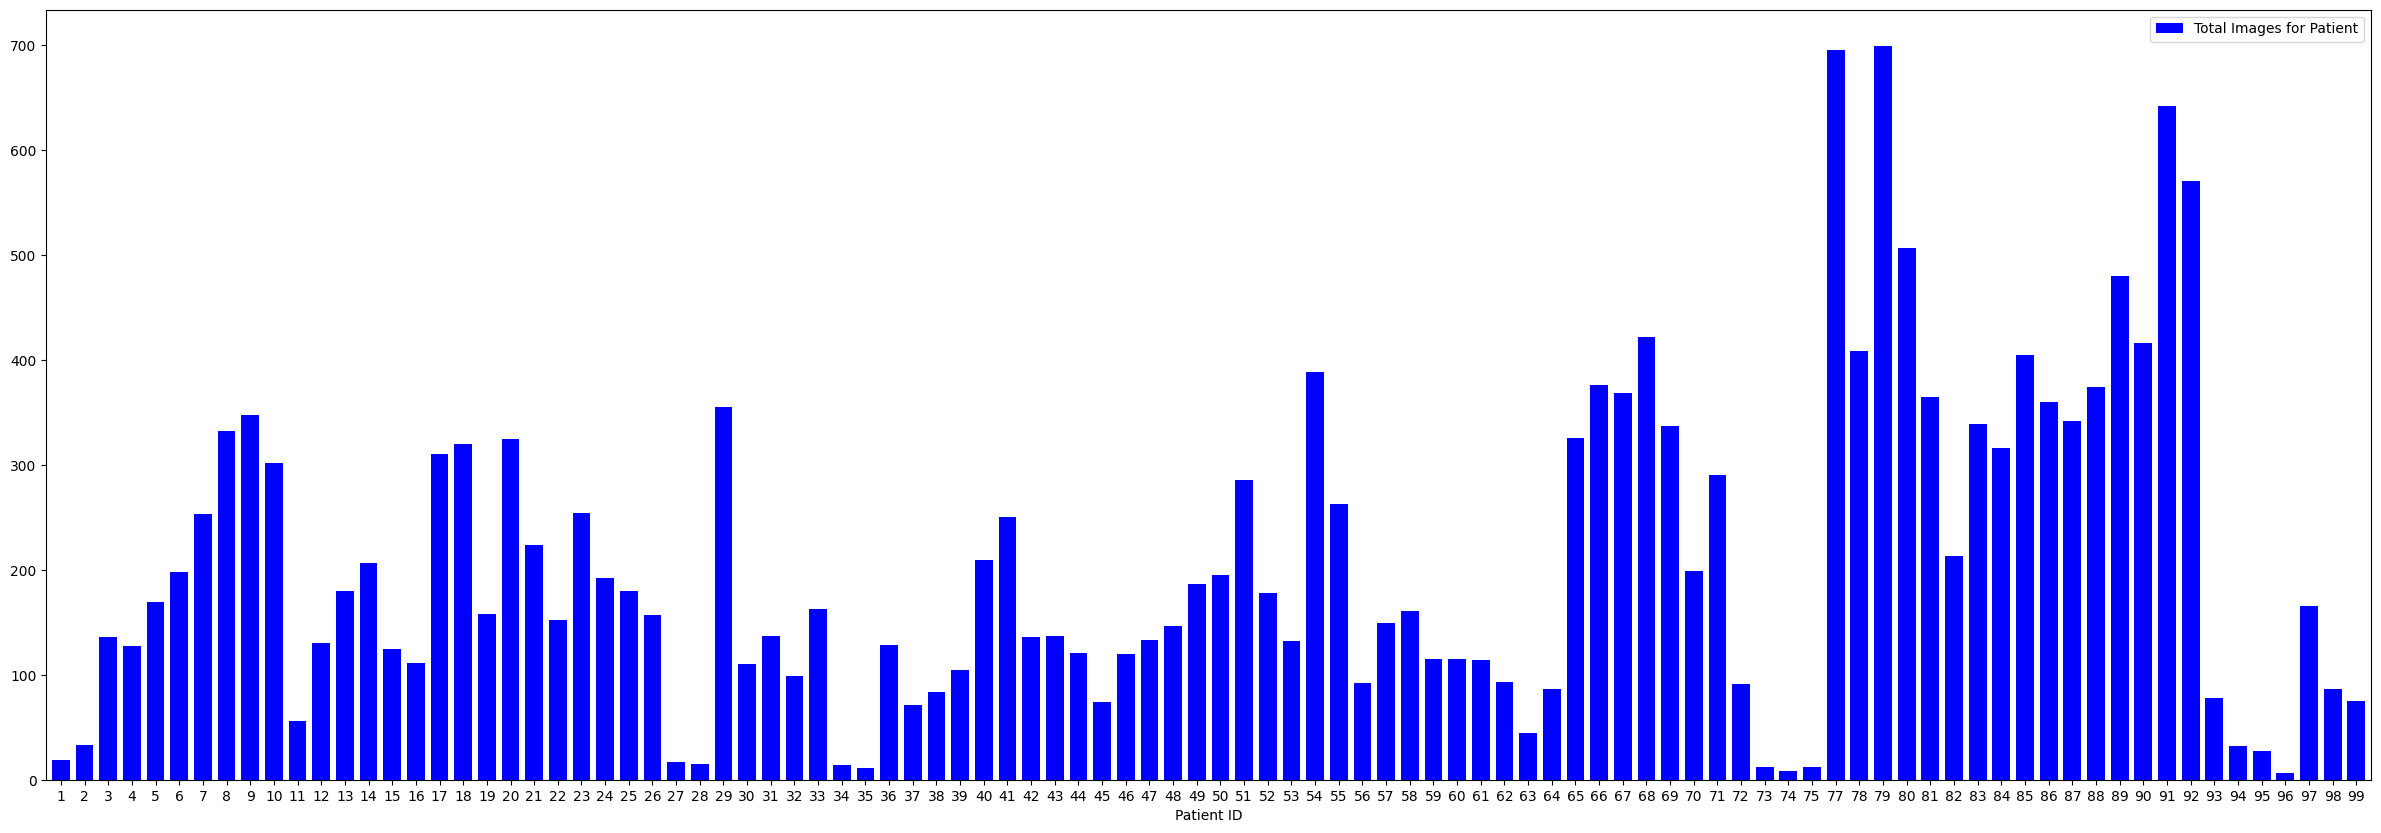

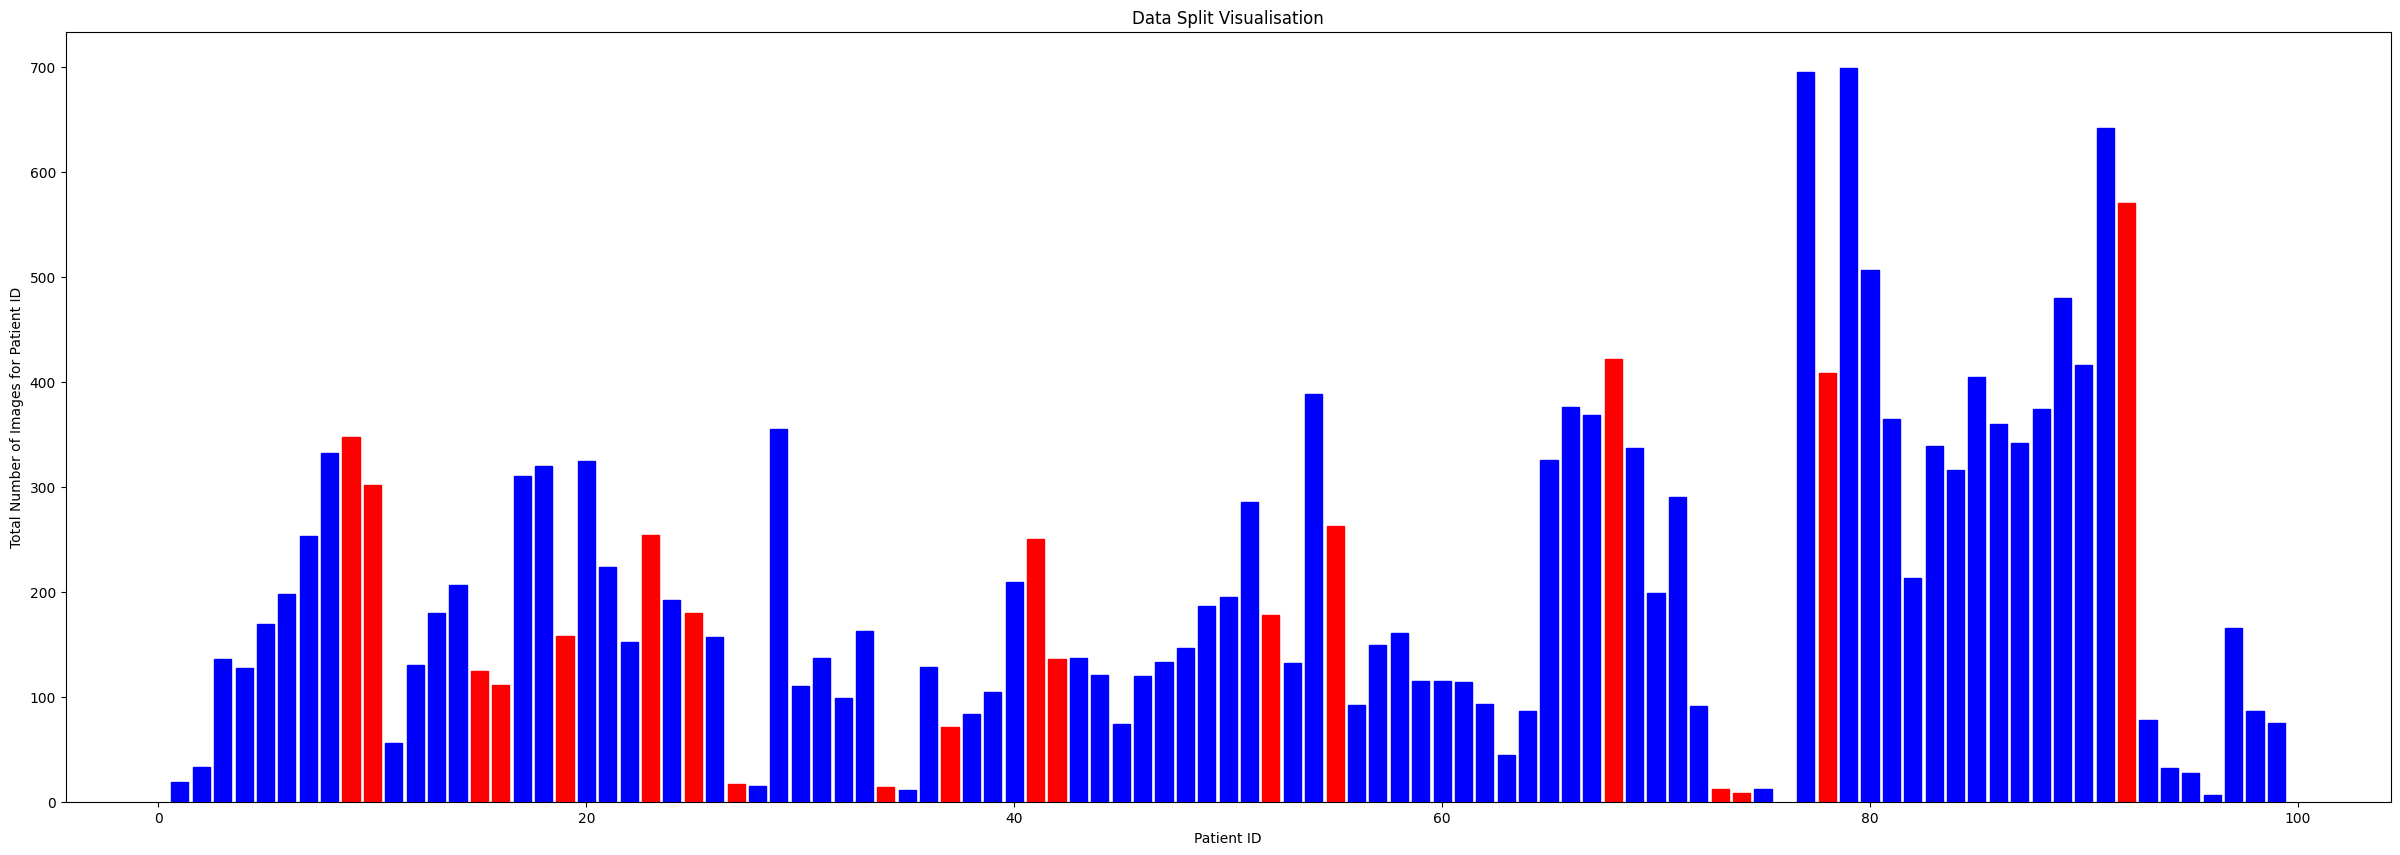

Training Data = BLUE
Average number of Training:  208.0

Testing Data = RED
Average number of Testing:  202.0


In [26]:
training_set_IC = dfPatientImagesCount_IC[dfPatientImagesCount_IC['Patient ID'].isin(trainingPatientID_IC)]
testing_set_IC = dfPatientImagesCount_IC[dfPatientImagesCount_IC['Patient ID'].isin(testingPatientID_IC)] 

training_set_IC['Colour'] = 'blue'
testing_set_IC['Colour'] = 'red'
dfSplitData = pd.concat([training_set_IC, testing_set_IC])
dfSplitData.sort_values(['Patient ID'], ascending=True, inplace=True)

dfPatientImagesCount_IC.plot(kind='bar', x='Patient ID', y='Total Images for Patient', color='blue', figsize=(30, 10), rot=0, width=0.75)

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.bar(dfSplitData['Patient ID'], dfSplitData['Total Images for Patient'])

for i, bar in enumerate(bars):
    bar.set_color(dfSplitData.iloc[i]['Colour'])

ax.set_xlabel('Patient ID')
ax.set_ylabel('Total Number of Images for Patient ID')
ax.set_title('Data Split Visualisation')

plt.show()

print("Training Data = BLUE")
print("Average number of Training: ", training_set_IC['Total Images for Patient'].mean().round())
print()
print("Testing Data = RED")
print("Average number of Testing: ", testing_set_IC['Total Images for Patient'].mean().round())

# Data for Cell Type Classification

In [27]:
# _CT == Cell Type Classification
trainingSetCellType = dfMain[dfMain['patientID'].isin(training_set_CT['Patient ID'])]
testingSetCellType = dfMain[dfMain['patientID'].isin(testing_set_CT['Patient ID'])]

print(trainingSetCellType)
print()
print(testingSetCellType)

      InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.png   fibroblast         0            0
1          22406          1  22406.png   fibroblast         0            0
2          22407          1  22407.png   fibroblast         0            0
3          22408          1  22408.png   fibroblast         0            0
4          22409          1  22409.png   fibroblast         0            0
...          ...        ...        ...          ...       ...          ...
9776       17819         59  17819.png       others         3            0
9777       17820         59  17820.png       others         3            0
9778       17821         59  17821.png       others         3            0
9779       17822         59  17822.png       others         3            0
9780       17823         59  17823.png       others         3            0

[8122 rows x 6 columns]

      InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous

# Data for Cancerous Classification

In [28]:
# _IC == Is Cancerous? Classification
trainingSetCancerous = dfJoined[dfJoined['patientID'].isin(training_set_IC['Patient ID'])]
testingSetCancerous = dfJoined[dfJoined['patientID'].isin(testing_set_IC['Patient ID'])]

print(trainingSetCancerous)
print()
print(testingSetCancerous)

       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0           22405          1  22405.png   fibroblast       0.0            0
1           22406          1  22406.png   fibroblast       0.0            0
2           22407          1  22407.png   fibroblast       0.0            0
3           22408          1  22408.png   fibroblast       0.0            0
4           22409          1  22409.png   fibroblast       0.0            0
...           ...        ...        ...          ...       ...          ...
10379       20028         99  20028.png          NaN       NaN            0
10380       20029         99  20029.png          NaN       NaN            0
10381       20030         99  20030.png          NaN       NaN            0
10382       20031         99  20031.png          NaN       NaN            0
10383       20032         99  20032.png          NaN       NaN            0

[16451 rows x 6 columns]

      InstanceID  patientID  ImageName cellTypeName  cellType

In [29]:
dfEpithelial = dfMain.loc[dfMain['cellTypeName'] == 'epithelial']
dfInflammatory = dfMain.loc[dfMain['cellTypeName'] == 'inflammatory']
dfFibroblast = dfMain.loc[dfMain['cellTypeName'] == 'fibroblast']
dfOthers= dfMain.loc[dfMain['cellTypeName'] == 'others']

In [30]:
cancerous = dfMain.loc[dfMain['isCancerous'] == 1]
non_cancerous = dfMain.loc[dfMain['isCancerous'] == 0]
print(cancerous.equals(dfEpithelial))

True


In [31]:
path = 'Image_classification_data/patch_images/' # image folder

In [32]:
dfIsCancerous = dfJoined.loc[dfJoined['isCancerous'] == 1]
print(dfIsCancerous)

      InstanceID  patientID ImageName cellTypeName  cellType  isCancerous
449          276          5   276.png   epithelial       2.0            1
450          277          5   277.png   epithelial       2.0            1
451          278          5   278.png   epithelial       2.0            1
452          279          5   279.png   epithelial       2.0            1
453          280          5   280.png   epithelial       2.0            1
...          ...        ...       ...          ...       ...          ...
7800        7667         88  7667.png          NaN       NaN            1
7801        7668         88  7668.png          NaN       NaN            1
7802        7669         88  7669.png          NaN       NaN            1
7803        7670         88  7670.png          NaN       NaN            1
7804        7671         88  7671.png          NaN       NaN            1

[7069 rows x 6 columns]


In [33]:
dfNotCancerous = dfJoined.loc[dfJoined['isCancerous'] == 0]
print(dfNotCancerous)

       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0           22405          1  22405.png   fibroblast       0.0            0
1           22406          1  22406.png   fibroblast       0.0            0
2           22407          1  22407.png   fibroblast       0.0            0
3           22408          1  22408.png   fibroblast       0.0            0
4           22409          1  22409.png   fibroblast       0.0            0
...           ...        ...        ...          ...       ...          ...
10379       20028         99  20028.png          NaN       NaN            0
10380       20029         99  20029.png          NaN       NaN            0
10381       20030         99  20030.png          NaN       NaN            0
10382       20031         99  20031.png          NaN       NaN            0
10383       20032         99  20032.png          NaN       NaN            0

[13211 rows x 6 columns]


In [34]:
nonCancerous = dfNotCancerous['ImageName'].tolist()
isCancerous = dfIsCancerous['ImageName'].tolist()

In [35]:
# randomly select 10 of each image from non-cancerous and cancerous lists
select_nonCancerous = np.random.choice(nonCancerous, 10, replace = False)
select_isCancerous = np.random.choice(isCancerous, 10, replace = False)

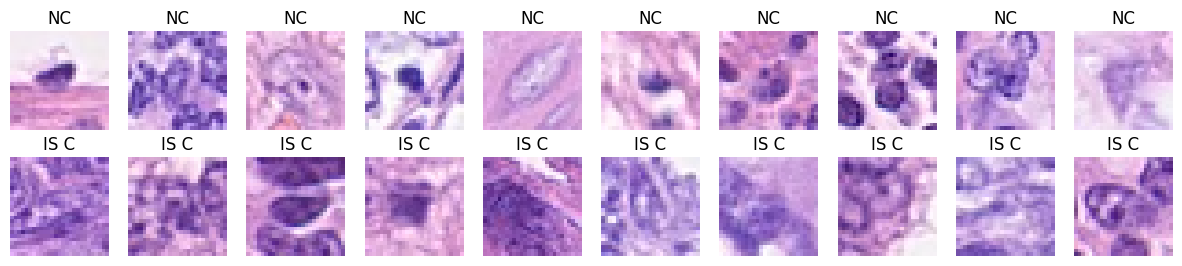

In [36]:
fig = plt.figure(figsize = (15,3))
rows = 2
columns = 12

for i in range(20):
    if i < 10:
        fp = path + select_nonCancerous[i]
        label = 'NC'
    else:
        fp = path + select_isCancerous[i-10]
        label = 'IS C'
        
    ax = fig.add_subplot(2, 10, i+1)
    fn = image.load_img(fp)
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [37]:
epithelial = dfEpithelial['ImageName'].tolist()
inflammatory = dfInflammatory['ImageName'].tolist()
fibroblast = dfFibroblast['ImageName'].tolist()
others= dfOthers['ImageName'].tolist()

# # randomly select 10 of each image from each cell type name
selectEpithelial = np.random.choice(epithelial, 10, replace = False)
selectInflammatory = np.random.choice(inflammatory, 10, replace = False)
selectFibroblast = np.random.choice(fibroblast, 10, replace = False)
selectOthers = np.random.choice(others, 10, replace = False)

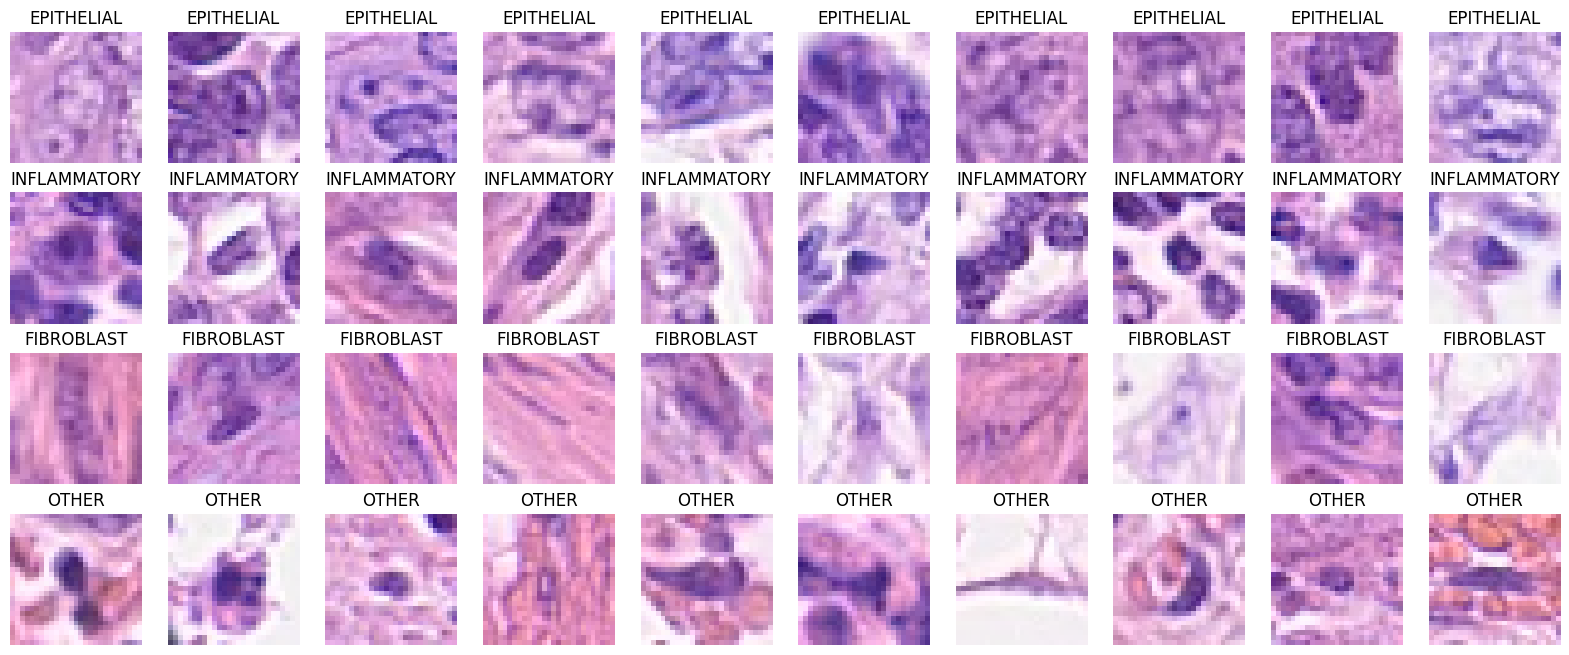

In [38]:
fig = plt.figure(figsize = (20,8))
rows = 4
columns = 12

for i in range(40):
    if i < 10:
        fp = path + selectEpithelial[i]
        label = 'EPITHELIAL'
    elif i < 20 :
        fp = path + selectInflammatory[i-10]
        label = 'INFLAMMATORY'
    elif i < 30 :
        fp = path + selectFibroblast[i-20]
        label = 'FIBROBLAST'
    elif i < 40 :
        fp = path + selectOthers[i-30]
        label = 'OTHER'
        
    ax = fig.add_subplot(4, 10, i+1)
    fn = image.load_img(fp)
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [39]:
def readImagesFromList(imgList, mode):
    images = []
    for filename in imgList:      
        img = cv2.imread(path + filename)
        if img is not None and mode == 'gray':
            img_flat = img.flatten()
            images.append(img_flat)
        elif img is not None:
            images.append(img)
    return images

ncImagesGS = readImagesFromList(nonCancerous, 'gray')
icImagesGS = readImagesFromList(isCancerous, 'gray')
ncImagesRGB = readImagesFromList(nonCancerous, None)
icImagesRGB = readImagesFromList(isCancerous, None)

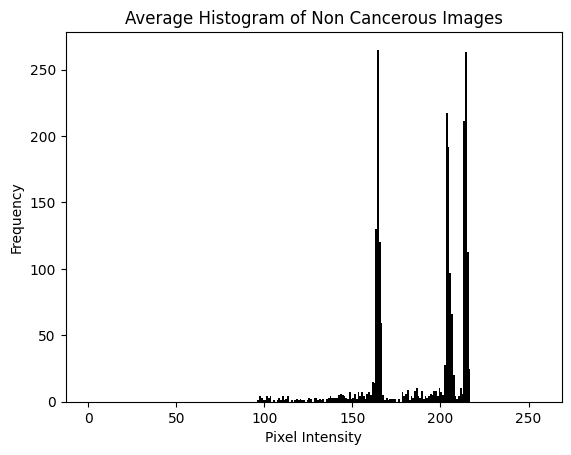

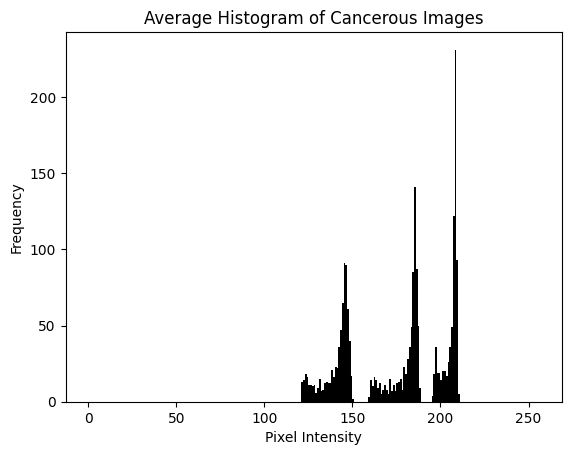

In [40]:
def imageHistograms(images, title):
#     images = read_images_from_list(imgList)
    pixel_values = np.array(images).mean(axis=0)
    plt.hist(pixel_values, bins=256, range=(0, 256), color='k')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

imageHistograms(ncImagesGS, 'Average Histogram of Non Cancerous Images')
imageHistograms(icImagesGS, 'Average Histogram of Cancerous Images')

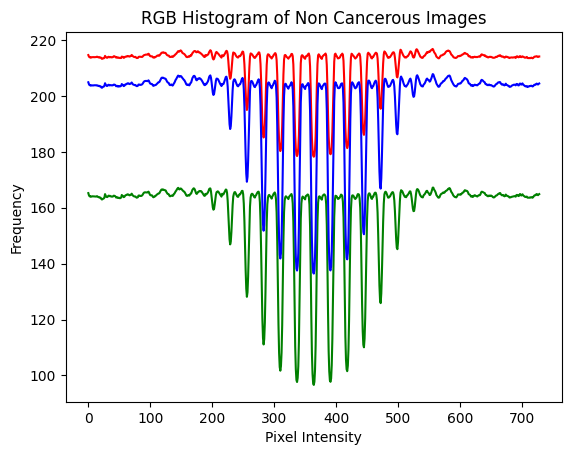

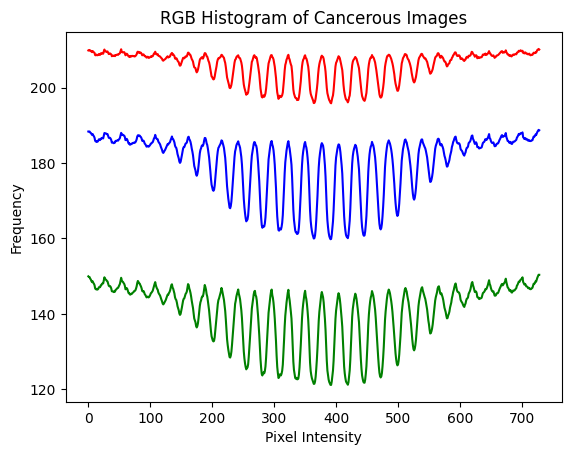

In [41]:
def colouredHistograms(images, title):
    red_values = []
    green_values = []
    blue_values = []

    for img in images:
        red_values.append(img[:,:,0].flatten())
        green_values.append(img[:,:,1].flatten())
        blue_values.append(img[:,:,2].flatten())

    red_values = np.array(red_values).mean(axis=0)
    green_values = np.array(green_values).mean(axis=0)
    blue_values = np.array(blue_values).mean(axis=0)

    plt.plot(red_values, color='r')
    plt.plot(green_values, color='g')
    plt.plot(blue_values, color='b')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

colouredHistograms(ncImagesRGB, 'RGB Histogram of Non Cancerous Images')
colouredHistograms(icImagesRGB, 'RGB Histogram of Cancerous Images')

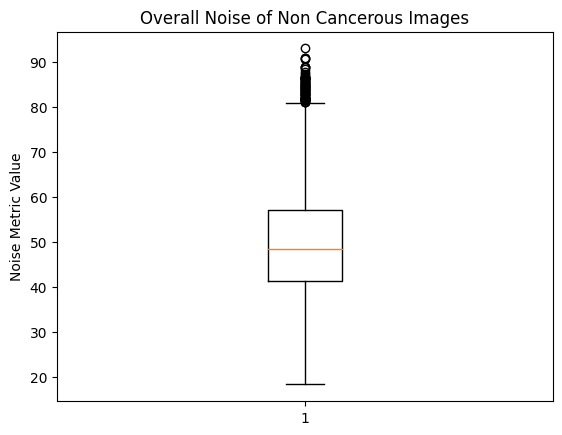

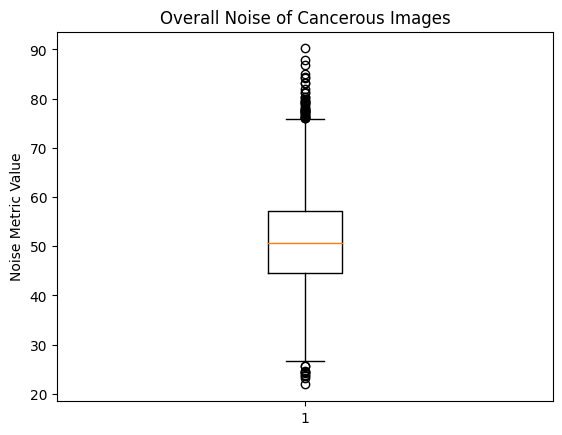

In [42]:
def calculateNoise(image, title):
    overall_noise = []    
    for img in image:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        noise = laplacian.std()
        overall_noise.append(noise)
    
    plt.boxplot(overall_noise)
    plt.title(title)
    plt.ylabel("Noise Metric Value")
    plt.show()

calculateNoise(ncImagesRGB, 'Overall Noise of Non Cancerous Images')
calculateNoise(icImagesRGB, 'Overall Noise of Cancerous Images')

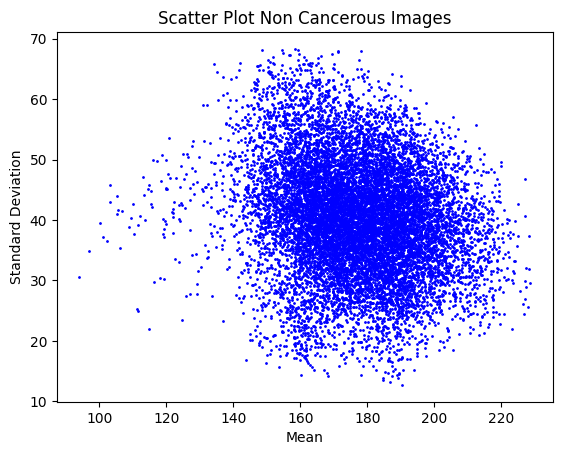

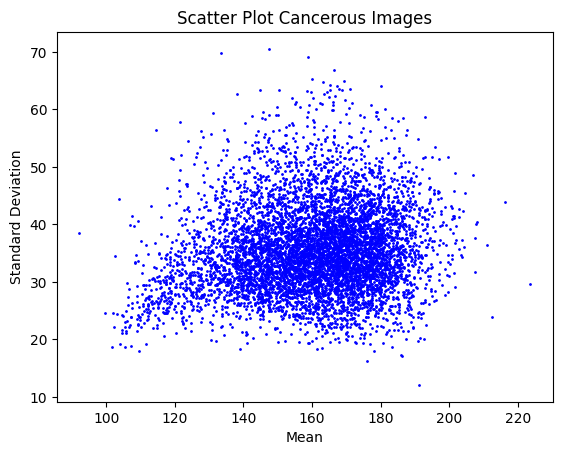

In [43]:
def extractFeatures(image, title):
    x_values = []
    y_values = []
    
    for img in image: 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mean = gray.mean()
        std = gray.std()
        x_values.append(mean)
        y_values.append(std)

    plt.scatter(x_values, y_values, s=1, color='blue')
    plt.title(title)
    plt.xlabel("Mean")
    plt.ylabel("Standard Deviation")
    plt.show()
    
extractFeatures(ncImagesRGB, 'Scatter Plot Non Cancerous Images')
extractFeatures(icImagesRGB, 'Scatter Plot Cancerous Images')

# Baseline Neural Network - Cell Type Classification

In [205]:
from sklearn.model_selection import train_test_split


with pd.option_context('mode.chained_assignment', None):
    trainingSetCellType, validationSetCellType = train_test_split(trainingSetCellType, test_size=0.25, 
                                            shuffle=True,random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainingSetCellType.shape[0], validationSetCellType.shape[0], testingSetCellType.shape[0]))

Train data : 2569, Val Data: 857, Test Data: 1774


In [206]:
print(trainingSetCellType)

      InstanceID  patientID  ImageName  cellTypeName cellType  isCancerous
5976          60         36     60.png    fibroblast        0            0
5846       19903         33  19903.png  inflammatory        1            0
6538        9918         41   9918.png  inflammatory        1            0
1252        4998          8   4998.png    epithelial        2            1
1645       13383         10  13383.png    fibroblast        0            0
...          ...        ...        ...           ...      ...          ...
6631       10012         41  10012.png  inflammatory        1            0
6519        9897         41   9897.png    fibroblast        0            0
4363       20193         23  20193.png    fibroblast        0            0
7169       18967         45  18967.png    fibroblast        0            0
7617         811         48    811.png    epithelial        2            1

[2569 rows x 6 columns]


In [207]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [208]:
# 27x27 pixels in an image and 3 layers due to coloured RGB Image
# Output classes = 4 due to 4 different possibilities of classification
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 100
OUTPUT_CLASSES = 4

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 2187)              0         
                                                                 
 dense_56 (Dense)            (None, 100)               218800    
                                                                 
 dense_57 (Dense)            (None, 4)                 404       
                                                                 
Total params: 219,204
Trainable params: 219,204
Non-trainable params: 0
_________________________________________________________________


In [209]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [210]:
# cellType == Class in this case
trainingSetCellType['cellType'] = trainingSetCellType['cellType'].astype('str')
validationSetCellType['cellType'] = validationSetCellType['cellType'].astype('str')

In [211]:
print(trainingSetCellType)
print(validationSetCellType)

      InstanceID  patientID  ImageName  cellTypeName cellType  isCancerous
5976          60         36     60.png    fibroblast        0            0
5846       19903         33  19903.png  inflammatory        1            0
6538        9918         41   9918.png  inflammatory        1            0
1252        4998          8   4998.png    epithelial        2            1
1645       13383         10  13383.png    fibroblast        0            0
...          ...        ...        ...           ...      ...          ...
6631       10012         41  10012.png  inflammatory        1            0
6519        9897         41   9897.png    fibroblast        0            0
4363       20193         23  20193.png    fibroblast        0            0
7169       18967         45  18967.png    fibroblast        0            0
7617         811         48    811.png    epithelial        2            1

[2569 rows x 6 columns]
      InstanceID  patientID  ImageName  cellTypeName cellType  isCancerous


In [212]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingSetCellType,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validationSetCellType,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 2569 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.


In [213]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 22:38:33.900653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 22:38:34.950005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


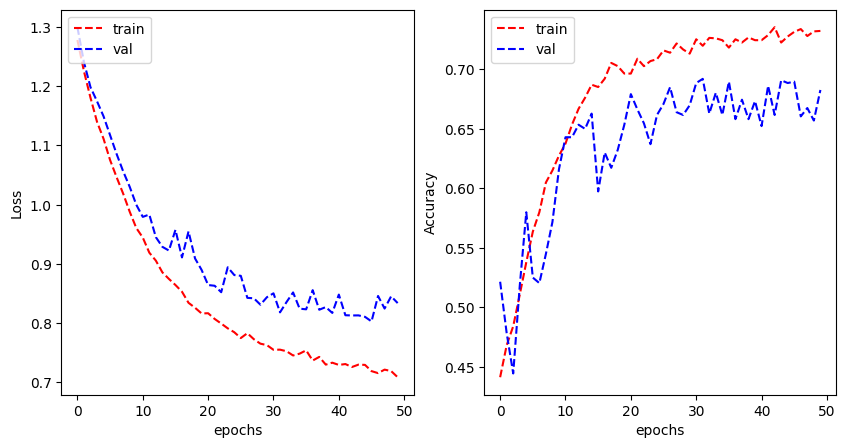

In [214]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Regularisation

In [183]:
reg_parameter = 0.05

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_parameter)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_parameter))
])

In [184]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [185]:
history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/4290883935.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)
2023-05-16 22:22:55.266626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 22:22:57.596715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


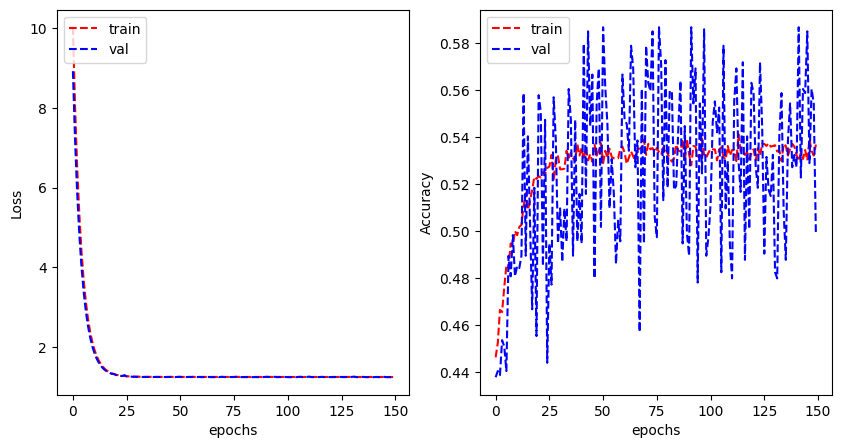

In [186]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Dropout

In [198]:
reg_lambda = 0.001

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [199]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [200]:
history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/3593438189.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)
2023-05-16 22:33:25.996503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 22:33:27.284092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


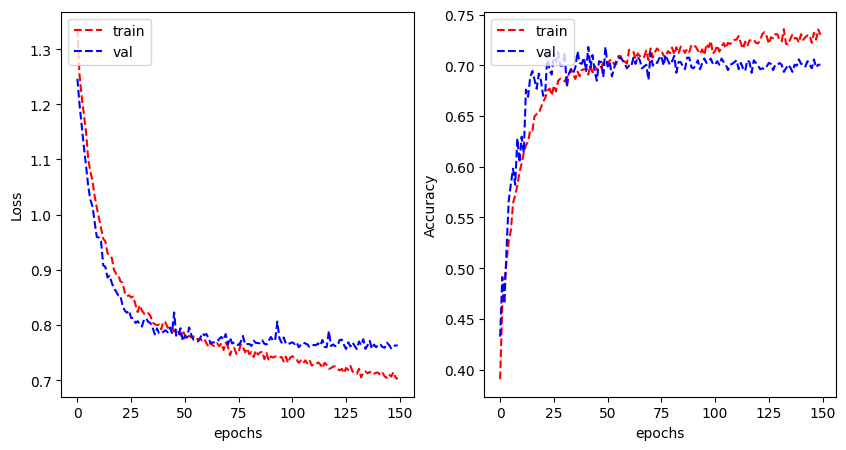

In [201]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Testing the Model

In [215]:
testingSetCellType['cellType'] = testingSetCellType['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=testingSetCellType,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(testingSetCellType)

Found 1774 validated image filenames belonging to 4 classes.
      InstanceID  patientID  ImageName cellTypeName cellType  isCancerous
188        18589          4  18589.png   fibroblast        0            0
189        18590          4  18590.png   fibroblast        0            0
190        18591          4  18591.png   fibroblast        0            0
191        18592          4  18592.png   fibroblast        0            0
192        18593          4  18593.png   fibroblast        0            0
...          ...        ...        ...          ...      ...          ...
9891        1625         60   1625.png   epithelial        2            1
9892        1626         60   1626.png   epithelial        2            1
9893        1627         60   1627.png   epithelial        2            1
9894        1628         60   1628.png   epithelial        2            1
9895        1629         60   1629.png   epithelial        2            1

[1774 rows x 6 columns]


/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/3309425605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingSetCellType['cellType'] = testingSetCellType['cellType'].astype('str')


 134/1774 [=>............................] - ETA: 1s - loss: 0.9066 - categorical_accuracy: 0.6791

2023-05-16 22:39:45.316354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1774/1774 [==============================] - 2s 1ms/step - loss: 0.9669 - categorical_accuracy: 0.5970


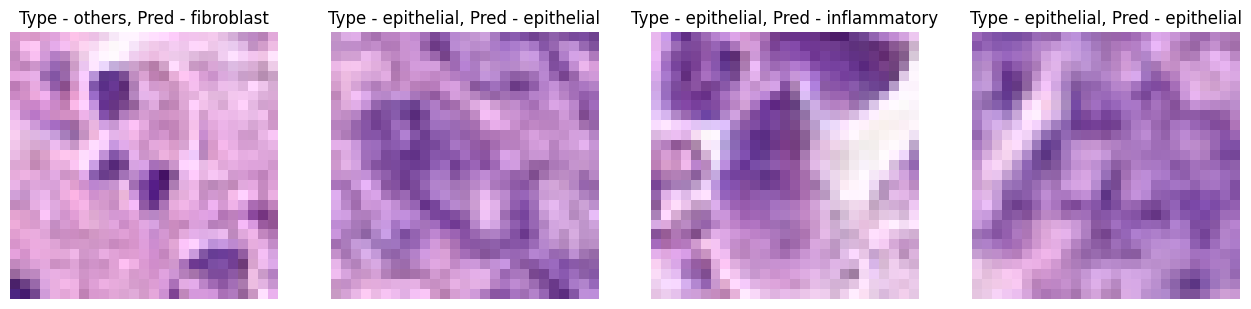

In [216]:
model.evaluate(test_generator)
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,10))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("Type - {}, Pred - {}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [217]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

 128/1774 [=>............................] - ETA: 1s - loss: 0.8896 - categorical_accuracy: 0.6328  

2023-05-16 22:39:47.928034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1774/1774 [==============================] - 2s 1ms/step - loss: 0.9669 - categorical_accuracy: 0.5970
Test Loss: 0.9668630957603455
Test Accuracy: 0.5969560146331787


# Baseline Neural Network - Cancerous Classification

In [228]:
with pd.option_context('mode.chained_assignment', None):
    trainingSetCancerous, validationSetCancerous = train_test_split(trainingSetCancerous, test_size=0.25, 
                                            shuffle=True,random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainingSetCancerous.shape[0], validationSetCancerous.shape[0], testingSetCancerous.shape[0]))

Train data : 6939, Val Data: 2314, Test Data: 3829


In [229]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 100
OUTPUT_CLASSES = 2

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 2187)              0         
                                                                 
 dense_60 (Dense)            (None, 100)               218800    
                                                                 
 dense_61 (Dense)            (None, 2)                 202       
                                                                 
Total params: 219,002
Trainable params: 219,002
Non-trainable params: 0
_________________________________________________________________


In [230]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [231]:
trainingSetCancerous['isCancerous'] = trainingSetCancerous['isCancerous'].astype('str')
validationSetCancerous['isCancerous'] = validationSetCancerous['isCancerous'].astype('str')

In [232]:
print(trainingSetCancerous)
print(validationSetCancerous)

      InstanceID  patientID  ImageName  cellTypeName  cellType isCancerous
6967        1279         43   1279.png        others       3.0           0
5239       17100         29  17100.png  inflammatory       1.0           0
7460        7302         88   7302.png           NaN       NaN           0
3881        9297         21   9297.png    epithelial       2.0           1
6863        9648         86   9648.png           NaN       NaN           0
...          ...        ...        ...           ...       ...         ...
9689       17724         59  17724.png  inflammatory       1.0           0
4098       10732         79  10732.png           NaN       NaN           0
3814         640         20    640.png    epithelial       2.0           1
1195        4936          8   4936.png    epithelial       2.0           1
8224        3570         51   3570.png    epithelial       2.0           1

[6939 rows x 6 columns]
      InstanceID  patientID  ImageName  cellTypeName  cellType isCancerous


In [233]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingSetCancerous,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validationSetCancerous,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')


Found 6939 validated image filenames belonging to 2 classes.
Found 2314 validated image filenames belonging to 2 classes.


In [115]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 20:39:22.712663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 20:39:29.699933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


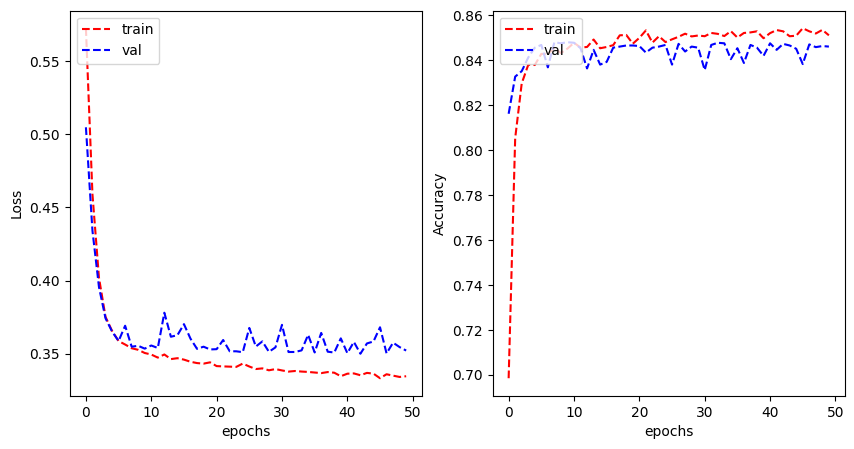

In [116]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Regularisation

In [142]:
reg_parameter = 0.05

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_parameter)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_parameter))
])

model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/3435188322.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)
2023-05-16 21:40:50.910131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 21:40:57.135068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


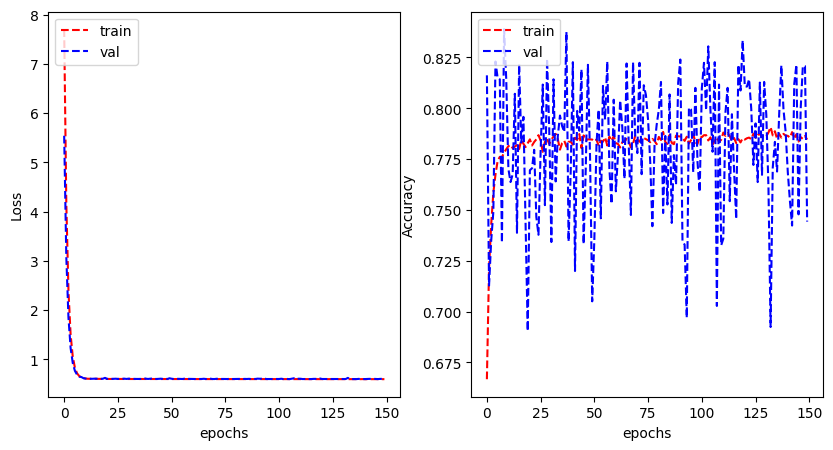

In [143]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Dropout

In [239]:
reg_lambda = 0.001

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/679979714.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)
2023-05-16 22:57:02.066216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 22:57:06.852121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


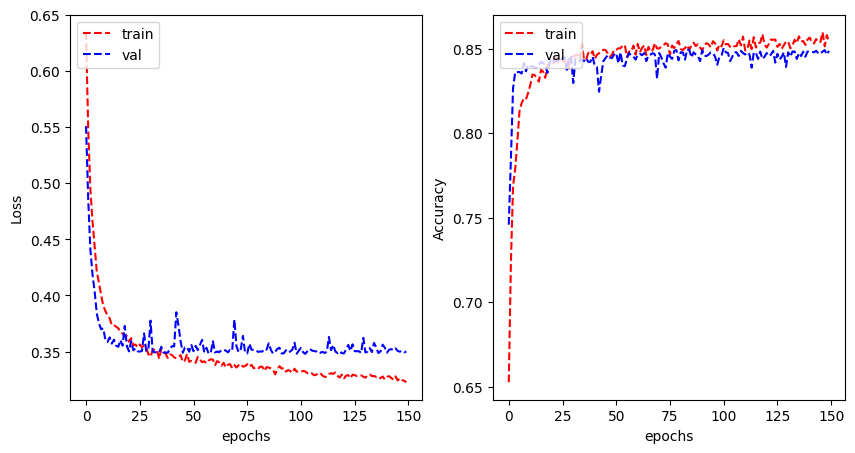

In [240]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Testing the Model

In [241]:
testingSetCancerous['isCancerous'] = testingSetCancerous['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=testingSetCancerous,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 3829 validated image filenames belonging to 2 classes.


/var/folders/7m/ppn2g1x93gg4s4v7r9s9qz140000gn/T/ipykernel_80196/125250808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingSetCancerous['isCancerous'] = testingSetCancerous['isCancerous'].astype('str')


 127/3829 [..............................] - ETA: 4s - loss: 0.3603 - categorical_accuracy: 0.8189

2023-05-16 23:05:10.096823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3829/3829 [==============================] - 4s 1ms/step - loss: 0.3754 - categorical_accuracy: 0.8268


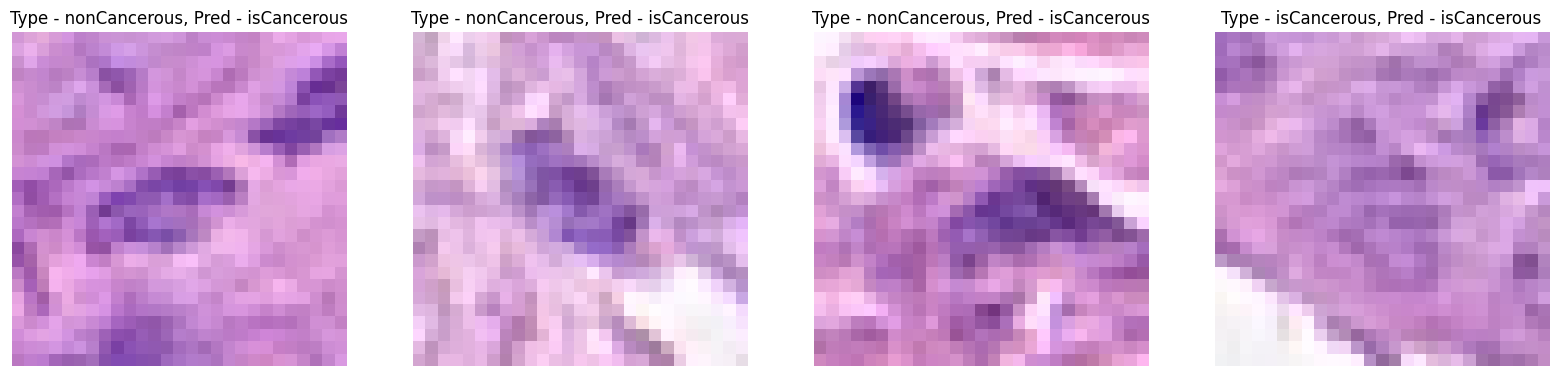

In [242]:
model_drop.evaluate(test_generator)
label_names = {'nonCancerous' : 0, 'isCancerous' : 1}

d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(25, 30))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("Type - {}, Pred - {}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [243]:
test_loss, test_accuracy = model_drop.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

  78/3829 [..............................] - ETA: 7s - loss: 0.3765 - categorical_accuracy: 0.8077

2023-05-16 23:05:14.739881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3829/3829 [==============================] - 4s 1ms/step - loss: 0.3754 - categorical_accuracy: 0.8268
Test Loss: 0.3753967583179474
Test Accuracy: 0.8268477320671082


# Baseline Deep Neural Network

In [ ]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Overfit

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Data Augment

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingSetCellType,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validationSetCellType,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:

reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG_3 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')